In [1]:
import sys
import os
import warnings

sys.path.append("../")
warnings.filterwarnings('ignore')

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf

2023-05-02 01:06:21.370034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_set = pd.read_csv("../CBIS-DDSM/csv/train.csv", index_col=0)
test_set = pd.read_csv("../CBIS-DDSM/csv/test.csv", index_col=0)
dicom_dataset = pd.read_csv("../CBIS-DDSM/csv/dicom_info.csv")

### Creating the preprocessed dataset for the whole image

In [5]:
new_dataset_train_path = "../preprocessed_dataset/train/"
new_dataset_val_path = "../preprocessed_dataset/validation/"

if not os.path.exists(new_dataset_train_path):
    os.makedirs(new_dataset_train_path+'MALIGNANT')
    os.makedirs(new_dataset_train_path+'BENIGN')
if not os.path.exists(new_dataset_val_path):
    os.makedirs(new_dataset_val_path+'MALIGNANT')
    os.makedirs(new_dataset_val_path+'BENIGN')

In [5]:
images = []
clahe=cv2.createCLAHE(clipLimit=40)

for p_id, label, image_path in train_set.values:
    image = cv2.imread(image_path, 0)
    gray_img_eqhist=cv2.equalizeHist(image)
    gray_clahe_image = cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2RGB)
    image = tf.image.resize(gray_clahe_image, (229, 229)).numpy().astype("uint8")
    save_dir = os.path.join(new_dataset_train_path, label, p_id+'.jpg')
    cv2.imwrite(save_dir, image)

2023-04-28 17:29:35.976673: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-28 17:29:35.976713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [6]:
for p_id, label, image_path in test_set.values:
    image = cv2.imread(image_path, 0)
    gray_img_eqhist=cv2.equalizeHist(image)
    gray_clahe_image = cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2RGB)
    image = tf.image.resize(gray_clahe_image, (229, 229)).numpy().astype("uint8")
    save_dir = os.path.join(new_dataset_val_path, label, p_id+'.jpg')
    cv2.imwrite(save_dir, image)

### mass-dataset cropped updated paths

In [6]:
mass_train = pd.read_csv("../CBIS-DDSM/csv/mass_case_description_train_set.csv")
mass_test = pd.read_csv("../CBIS-DDSM/csv/mass_case_description_test_set.csv")

In [39]:
def generate_p_ids(df, dicom_dataset, dataset_type):
    p_ids = []
    for i, data in enumerate(df[["patient_id", "left or right breast", "image view", "abnormality id"]].values):

        p_id, side, view, abnormalitiy_id = data
        full_image_id = dataset_type + "_" + p_id + "_" + side + "_" + view 
        cropped_image_id = dataset_type + "_" + p_id + "_" + side + "_" + view + "_" + str(abnormalitiy_id)
        roi_image_path = dataset_type + "_" + p_id + "_" + side + "_" + view + "_" + str(abnormalitiy_id)
        
        full_image_series = dicom_dataset[["image_path", "PatientID", "SeriesDescription"]][(dicom_dataset["PatientID"] == full_image_id) & 
                                                                (dicom_dataset["SeriesDescription"] == "full mammogram images")]
        cropped_path_series = dicom_dataset[["image_path", "PatientID", "SeriesDescription"]][(dicom_dataset["PatientID"] == cropped_image_id) & 
                                                                (dicom_dataset["SeriesDescription"] == "cropped images")] 
        roi_path_series = dicom_dataset[["image_path", "PatientID", "SeriesDescription"]][(dicom_dataset["PatientID"] == roi_image_path) & 
                                                                (dicom_dataset["SeriesDescription"] == "ROI mask images")]
        
        
        if len(full_image_series.values) > 0:
            full_image_path = "../" + full_image_series.values[0][0]
            df["image file path"][i] = full_image_path
        else:
            df["image file path"][i] = None
            
        if len(cropped_path_series.values) > 0:
            cropped_image_path = "../" + cropped_path_series.values[0][0]
            df["cropped image file path"][i] = cropped_image_path
        else:
            df["cropped image file path"][i] = None
            
        if len(roi_path_series.values) > 0:
            roi_image_path = "../" + roi_path_series.values[0][0]
            df["ROI mask file path"][i] = roi_image_path
        else:
            df["ROI mask file path"][i] = None
            
    return df

In [40]:
mass_train_df = generate_p_ids(mass_train, dicom_dataset, "Mass-Training")
mass_test_df = generate_p_ids(mass_test, dicom_dataset, "Mass-Test")

In [41]:
mass_train_df.to_csv("../CBIS-DDSM/csv/mass_train_updated.csv")
mass_test_df.to_csv("../CBIS-DDSM/csv/mass_test_updated.csv")

### calcification-dataset updated paths

In [42]:
calc_train = pd.read_csv("../CBIS-DDSM/csv/calc_case_description_train_set.csv")
calc_test = pd.read_csv("../CBIS-DDSM/csv/calc_case_description_test_set.csv")

In [43]:
calc_train_df = generate_p_ids(calc_train, dicom_dataset, "Calc-Training")
calc_test_df = generate_p_ids(calc_test, dicom_dataset, "Calc-Test")

In [44]:
calc_train_df.to_csv("../CBIS-DDSM/csv/calc_train_updated.csv")
calc_test_df.to_csv("../CBIS-DDSM/csv/calc_test_updated.csv")

## Testing CLAHE

In [18]:
image = cv2.imread(image_path, 0)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

NameError: name 'image_path' is not defined

In [252]:
hist,bins = np.histogram(image.flatten(),256,[0,256]) 

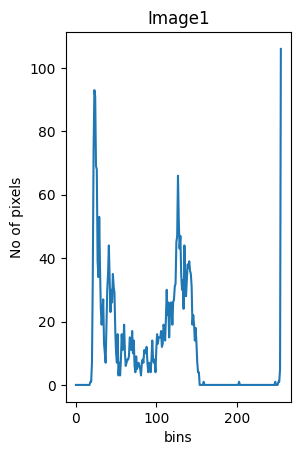

In [253]:
hist=cv2.calcHist(image,[0],None,[256],[0,256])
plt.subplot(121)
plt.title("Image1")
plt.xlabel('bins')
plt.ylabel("No of pixels")
plt.plot(hist)
plt.show()

In [16]:
gray_img_eqhist=cv2.equalizeHist(image)
hist,bins = np.histogram(gray_img_eqhist.flatten(),256,[0,256])
plt.subplot(121)
plt.plot(hist)
plt.show()

NameError: name 'image' is not defined

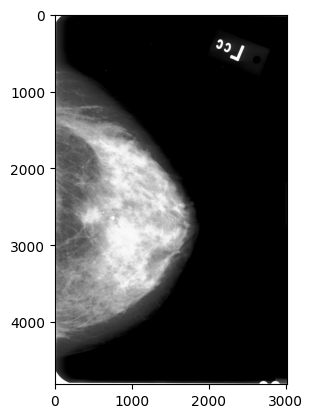

In [255]:
plt.imshow(cv2.cvtColor(gray_img_eqhist, cv2.COLOR_BGR2RGB))

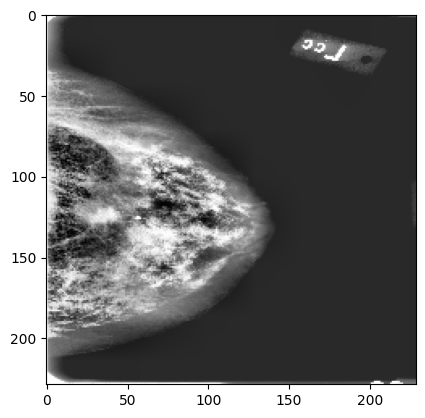

In [257]:
clahe=cv2.createCLAHE(clipLimit=40)
gray_img_clahe=cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2BGR)
im = tf.image.resize(gray_img_clahe, (229, 229)).numpy().astype(np.uint8)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))